<a href="https://colab.research.google.com/github/callumbloys/AI_Assignment/blob/main/VanomousSpeciesAIProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Venomous Species Classification



In [196]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [197]:
!unzip '/content/gdrive/MyDrive/Poisonous_Species.zip' > /dev/null

In [198]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

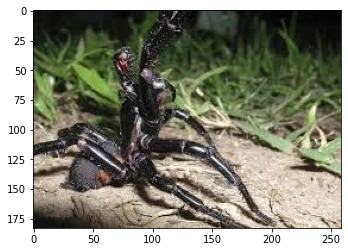

In [199]:
image = mpimg.imread('/content/Poisonous_Species/Poisonous_Species/train/Funnel_Web_Spider/AnyConv.com__images (25).png')
plt.imshow(image)
plt.show()

In [200]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print('CUDA is not available. Training on CPU.')
else:
  print('CUDA is available. Training on GPU.')

CUDA is available. Training on GPU.


In [201]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [202]:
data_dir = 'Poisonous_Species/Poisonous_Species'

batch_size = 8

train_transform = transforms.Compose([transforms.Resize(236),
                                transforms.RandomRotation(5), 
                                transforms.CenterCrop(224), 
                                transforms.RandomHorizontalFlip(), 
                                transforms.ToTensor(), 
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])]) 

transform = transforms.Compose([transforms.Resize(224), 
                                transforms.CenterCrop(224), 
                                transforms.ToTensor(), 
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])]) 

train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transform)
val_data = datasets.ImageFolder(data_dir + '/val', transform=transform)
test_data = datasets.ImageFolder(data_dir + '/test', transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True)

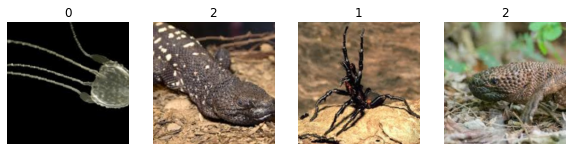

In [203]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    imshow(images[ii], ax=ax, normalize=True)
    ax.set_title(str(labels[ii].item())) 

In [204]:
#########################################################################
# use a ResNet18 network
# #######################################################################
import torch.nn as nn
import torchvision.models as models

model = models.resnet18(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)

if train_on_gpu:
    model.cuda()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [205]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [206]:
n_epochs = 20

valid_loss_min = np.Inf 

train_losses, val_losses = [], []

for epoch in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() 
    for data, target in train_loader:
       
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
       
        optimizer.zero_grad()    
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval() 
    for data, target in val_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
        
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(val_loader.sampler)

    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'MLP_model.pt')
        torch.save(model.state_dict(), '/content/gdrive/MyDrive/MLP_model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.788120 	Validation Loss: 3.736731
Validation loss decreased (inf --> 3.736731).  Saving model ...
Epoch: 2 	Training Loss: 0.695699 	Validation Loss: 1.232823
Validation loss decreased (3.736731 --> 1.232823).  Saving model ...
Epoch: 3 	Training Loss: 0.447733 	Validation Loss: 0.876925
Validation loss decreased (1.232823 --> 0.876925).  Saving model ...
Epoch: 4 	Training Loss: 0.338261 	Validation Loss: 0.871712
Validation loss decreased (0.876925 --> 0.871712).  Saving model ...
Epoch: 5 	Training Loss: 0.207582 	Validation Loss: 1.059753
Epoch: 6 	Training Loss: 0.374350 	Validation Loss: 1.274244
Epoch: 7 	Training Loss: 0.238833 	Validation Loss: 0.550573
Validation loss decreased (0.871712 --> 0.550573).  Saving model ...
Epoch: 8 	Training Loss: 0.154130 	Validation Loss: 0.725148
Epoch: 9 	Training Loss: 0.307922 	Validation Loss: 0.868721
Epoch: 10 	Training Loss: 0.184486 	Validation Loss: 0.771553
Epoch: 11 	Training Loss: 0.222060 	Validation Lo

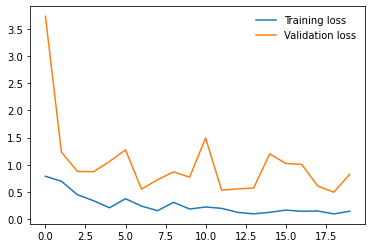

In [207]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)

In [208]:
model.load_state_dict(torch.load('MLP_model.pt'))

<All keys matched successfully>

In [209]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() 

for data, target in test_loader:
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(4):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.169760

Test Accuracy of     0: 100% (10/10)
Test Accuracy of     1: 92% (12/13)
Test Accuracy of     2: 100% (13/13)
Test Accuracy of     3: 87% (21/24)

Test Accuracy (Overall): 93% (56/60)


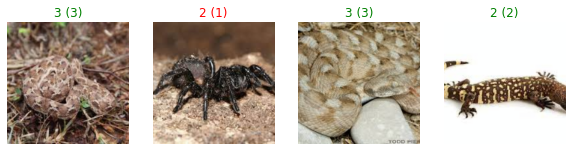

In [210]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

if train_on_gpu:
    images = images.cuda()

output = model(images)
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    imshow(images.cpu()[ii], ax=ax, normalize=True)
    ax.set_title("{} ({})".format(str(preds[ii].item()), str(labels[ii].item())),
                 color=("green" if preds[ii]==labels[ii] else "red")) 

In [259]:
# dataset directory
data_dir = 'Poisonous_Species/Poisonous_Species'

# define batch size
batch_size = 8

# define transforms (colour)
transform = transforms.Compose([transforms.Resize(64), # resize to 32x?
                                transforms.CenterCrop(64), # take a square (32x32) crop from the centre
                                transforms.ToTensor(), # convert data to torch.FloatTensor
                                transforms.Normalize([0.5, 0.5, 0.5],
                                                     [0.5, 0.5, 0.5])]) # normalise with mean 0.5 and standard deviation 0.5 for each colour channel

# choose the training, validation and test datasets
train_data = datasets.ImageFolder(data_dir + '/train', transform=transform)
val_data = datasets.ImageFolder(data_dir + '/val', transform=transform)
test_data = datasets.ImageFolder(data_dir + '/test', transform=transform)

# prepare the data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True)

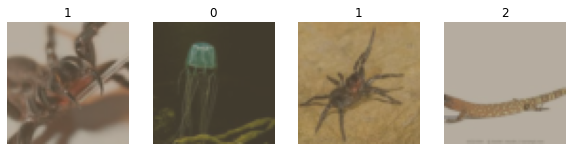

In [260]:
# obtain one batch of training images
data_iter = iter(train_loader)
images, labels = next(data_iter)

# plot the first 4 images in the batch, along with the corresponding labels
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    imshow(images[ii], ax=ax, normalize=True)
    ax.set_title(str(labels[ii].item())) 
# 0 is Lion's mane Jellyfish, 1 is Moon Jellyfish, 2 is Pacific Sea Nettle, 3 is White spotted Jellyfish

In [213]:
#########################################################################
# this code is different to last week - here we define a CNN architecture
#########################################################################

import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer 1 (input 32x32x3)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) # torch.nn.Conv2d(in_channels, out_channels, kernel_size)
        # convolutional layer 2 (input 16x16x16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer 3 (input 8x8x32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer 
        self.pool = nn.MaxPool2d(2, 2) # torch.nn.MaxPool2d(kernel_size, stride)
        # fully connected layer 1 (input 4x4x64)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        # fully connected layer 2 (input 500, output 4 - four classes)
        self.fc2 = nn.Linear(500, 4) 
        # dropout layer
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 64 * 4 * 4)
        # dropout layer
        x = self.dropout(x)
        # hidden layer and relu
        x = F.relu(self.fc1(x))
        # dropout layer
        x = self.dropout(x)
        # add output layer
        x = self.fc2(x)
        
        return x

# create the CNN
model = Net()
print(model)

#########################################################################
#########################################################################

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=4, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [214]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [215]:
# number of epochs to train the model
n_epochs = 20

# initialise tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

# create empty lists to store the training and validation losses
train_losses, val_losses = [], []

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data, target in val_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item()*data.size(0)
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(val_loader.sampler)

    # store the training and validation losses for later visualisation
    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'CNN_model.pt') # save in colab
        torch.save(model.state_dict(), '/content/gdrive/MyDrive/CNN_model.pt') # save in google drive
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.049290 	Validation Loss: 1.302102
Validation loss decreased (inf --> 1.302102).  Saving model ...
Epoch: 2 	Training Loss: 0.785441 	Validation Loss: 1.581457
Epoch: 3 	Training Loss: 0.794220 	Validation Loss: 1.299141
Validation loss decreased (1.302102 --> 1.299141).  Saving model ...
Epoch: 4 	Training Loss: 0.604452 	Validation Loss: 1.033249
Validation loss decreased (1.299141 --> 1.033249).  Saving model ...
Epoch: 5 	Training Loss: 0.545510 	Validation Loss: 1.253200
Epoch: 6 	Training Loss: 0.478302 	Validation Loss: 1.373792
Epoch: 7 	Training Loss: 0.311731 	Validation Loss: 1.129717
Epoch: 8 	Training Loss: 0.300144 	Validation Loss: 0.995047
Validation loss decreased (1.033249 --> 0.995047).  Saving model ...
Epoch: 9 	Training Loss: 0.171205 	Validation Loss: 1.320878
Epoch: 10 	Training Loss: 0.110344 	Validation Loss: 1.705118
Epoch: 11 	Training Loss: 0.098877 	Validation Loss: 1.468894
Epoch: 12 	Training Loss: 0.108119 	Validation Loss: 2.4

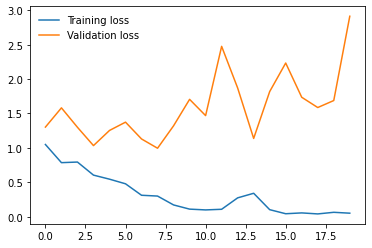

In [216]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)

In [217]:
model.load_state_dict(torch.load('CNN_model.pt'))

<All keys matched successfully>

In [218]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()

for data, target in test_loader:
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(4):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.383532

Test Accuracy of     0: 100% (10/10)
Test Accuracy of     1: 84% (11/13)
Test Accuracy of     2: 69% ( 9/13)
Test Accuracy of     3: 87% (21/24)

Test Accuracy (Overall): 85% (51/60)


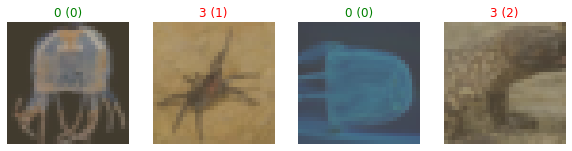

In [219]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

output = model(images)
_, preds = torch.max(output, 1)

fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    imshow(images[ii], ax=ax, normalize=True)
    ax.set_title("{} ({})".format(str(preds[ii].item()), str(labels[ii].item())),
                 color=("green" if preds[ii]==labels[ii] else "red")) 

In [220]:
!git clone https://github.com/yiskw713/SmoothGradCAMplusplus.git

Cloning into 'SmoothGradCAMplusplus'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 47 (delta 13), reused 24 (delta 11), pack-reused 20
Unpacking objects: 100% (47/47), done.


In [221]:
%cd /content/SmoothGradCAMplusplus/

/content/SmoothGradCAMplusplus


In [222]:
import cam

In [223]:
%matplotlib inline

import numpy as np
import skimage.transform
import torch
import torch.nn as nn
import torch.nn. functional as F

from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torchvision.utils import save_image

from cam import CAM, GradCAM, GradCAMpp, SmoothGradCAMpp
from utils.visualize import visualize, reverse_normalize
from utils.imagenet_labels import label2idx, idx2label

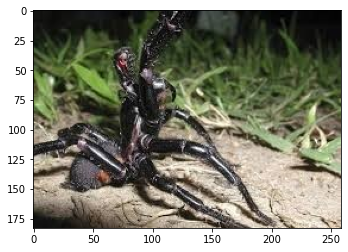

In [224]:
image = Image.open('/content/Poisonous_Species/Poisonous_Species/train/Funnel_Web_Spider/AnyConv.com__images (25).png')
imshow(image)

In [225]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

preprocess = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

In [226]:
tensor = preprocess(image)
tensor = tensor.unsqueeze(0)

In [227]:
model = models.resnet18(pretrained=True)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [228]:
target_layer = model.layer4[1].conv2
wrapped_model = SmoothGradCAMpp(model, target_layer, n_samples=25, stdev_spread=0.15)

In [229]:
cam, idx = wrapped_model(tensor)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


predicted class ids 71	 probability 0.44474896788597107


In [230]:
print(idx2label[idx])

scorpion


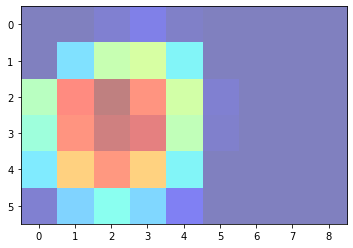

In [231]:
imshow(cam.squeeze().numpy(), alpha=0.5, cmap='jet')

In [232]:
img = reverse_normalize(tensor)

In [233]:
heatmap = visualize(img, cam)

In [234]:
save_image(heatmap, './sample/{}_smoothgradcampp.png'.format(idx2label[idx]).replace(" ", "_").replace(",", ""))

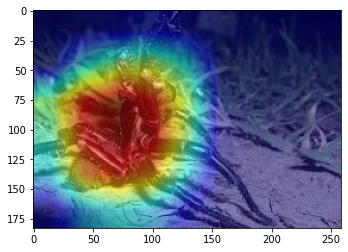

In [235]:
hm = (heatmap.squeeze().numpy().transpose(1, 2, 0))
imshow(hm)

In [236]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print('CUDA is not available. Training on CPU.')
else:
  print('CUDA is available. Training on GPU.')

CUDA is available. Training on GPU.


In [237]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [238]:
data_dir = 'Poisonous_Species/Poisonous_Species'

batch_size = 8

train_transform = transforms.Compose([transforms.Resize(236), 
                                transforms.RandomRotation(5), 
                                transforms.CenterCrop(224), 
                                transforms.RandomHorizontalFlip(), 
                                transforms.ToTensor(), 
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])]) 

transform = transforms.Compose([transforms.Resize(224), 
                                transforms.CenterCrop(224), 
                                transforms.ToTensor(), 
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])])

train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transform)
val_data = datasets.ImageFolder(data_dir + '/val', transform=transform)
test_data = datasets.ImageFolder(data_dir + '/test', transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True)

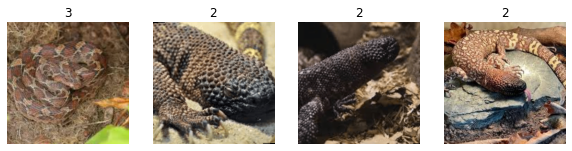

In [239]:
data_iter = iter(train_loader)
images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    imshow(images[ii], ax=ax, normalize=True)
    ax.set_title(str(labels[ii].item())) 

In [240]:
#########################################################################
# use a ResNet18 network
# #########################################################################
# NB This network requires an image input size of 3x224x224 and normalised using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

import torch.nn as nn
import torchvision.models as models

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)
if train_on_gpu:
    model.cuda()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [241]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [242]:
n_epochs = 20

valid_loss_min = np.Inf 
train_losses, val_losses = [], []

for epoch in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() 
    for data, target in train_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval() 
    for data, target in val_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
        
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(val_loader.sampler)

    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'resnet18_model_fine_tune_aug.pt') # save in colab
        torch.save(model.state_dict(), '/content/gdrive/MyDrive/resnet18_model_fine_tune_aug.pt') # save in google drive
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.706027 	Validation Loss: 10.213680
Validation loss decreased (inf --> 10.213680).  Saving model ...
Epoch: 2 	Training Loss: 0.641007 	Validation Loss: 0.834196
Validation loss decreased (10.213680 --> 0.834196).  Saving model ...
Epoch: 3 	Training Loss: 0.594076 	Validation Loss: 0.898769
Epoch: 4 	Training Loss: 0.352603 	Validation Loss: 0.743056
Validation loss decreased (0.834196 --> 0.743056).  Saving model ...
Epoch: 5 	Training Loss: 0.315591 	Validation Loss: 0.703676
Validation loss decreased (0.743056 --> 0.703676).  Saving model ...
Epoch: 6 	Training Loss: 0.290429 	Validation Loss: 1.045918
Epoch: 7 	Training Loss: 0.297610 	Validation Loss: 0.842109
Epoch: 8 	Training Loss: 0.300387 	Validation Loss: 1.221093
Epoch: 9 	Training Loss: 0.182073 	Validation Loss: 0.890022
Epoch: 10 	Training Loss: 0.146908 	Validation Loss: 1.009929
Epoch: 11 	Training Loss: 0.198972 	Validation Loss: 1.734447
Epoch: 12 	Training Loss: 0.322735 	Validation Loss: 

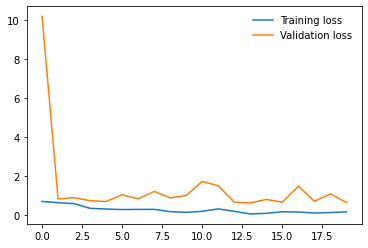

In [243]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)

In [244]:
model.load_state_dict(torch.load('MLP_model.pt'))

<All keys matched successfully>

In [245]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()

for data, target in test_loader:
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(4):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.169760

Test Accuracy of     0: 100% (10/10)
Test Accuracy of     1: 92% (12/13)
Test Accuracy of     2: 100% (13/13)
Test Accuracy of     3: 87% (21/24)

Test Accuracy (Overall): 93% (56/60)


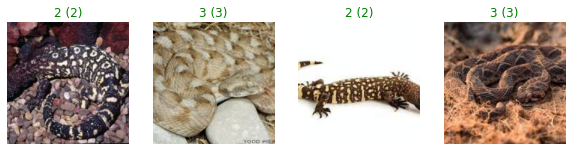

In [246]:

dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the first 4 images in the batch, along with the corresponding labels
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    imshow(images.cpu()[ii], ax=ax, normalize=True)
    ax.set_title("{} ({})".format(str(preds[ii].item()), str(labels[ii].item())),
                 color=("green" if preds[ii]==labels[ii] else "red")) 
# 0 is Lion's mane Jellyfish, 1 is Moon Jellyfish, 2 is Pacific Sea Nettle, 3 is White spotted Jellyfish

In [247]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print('CUDA is not available. Training on CPU.')
else:
  print('CUDA is available. Training on GPU.')

CUDA is available. Training on GPU.


In [248]:
# load model
import torch.nn as nn
import torchvision.models as models
from torch.autograd import Variable

# load a pre-trained ResNet network with 18 layers
model = models.resnet18(pretrained=True)
# # remove the final layer so the output of the network is now a 512 feature vector
model = nn.Sequential(*list(model.children())[:-1])

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

print(model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [249]:
# imshow function for displaying images
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [250]:
# dataset directory
data_dir = 'Poisonous_Species/Poisonous_Species'

# define batch size
batch_size = 100

# define transforms
transform = transforms.Compose([transforms.Resize(224), # resize to 224x?
                                transforms.CenterCrop(224), # take a square (224x224) crop from the centre
                                transforms.ToTensor(), # convert data to torch.FloatTensor
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])]) # normalise for each colour channel

# choose the test dataset
test_data = datasets.ImageFolder(data_dir + '/test', transform=transform)

# prepare the data loader
test_loader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True)

In [251]:
# for t-SNE we will use a trained network to extract features for each image
# we will remove the final layer of the network so the output a 512 feature vector

# load model
import torch.nn as nn
import torchvision.models as models
from torch.autograd import Variable

# load a pre-trained ResNet network with 18 layers
model = models.resnet18(pretrained=True)
# # remove the final layer so the output of the network is now a 512 feature vector
model = nn.Sequential(*list(model.children())[:-1])

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

print(model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [252]:
# Load previously trained model

# create a new model with ResNet18 architecture
myModel = models.resnet18(pretrained=True)
# get the number of inputs for the final layer (fc) of the network
num_ftrs = myModel.fc.in_features
# replace the final layer so that the output is four classes
myModel.fc = nn.Linear(num_ftrs, 4)
# load previously trained model
myModel.load_state_dict(torch.load('/content/gdrive/MyDrive/MLP_model.pt'))
# remove the final layer so the output of the network is now a 512 feature vector
myModel = nn.Sequential(*list(myModel.children())[:-1])

# move tensors to GPU if CUDA is available
if train_on_gpu:
    myModel.cuda()

# print(myModel)

In [253]:
# Visualize Sample Test Results

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# sample outputs
imageNet_feats = model(images)
creature_feats = myModel(images)

# put on cpu, convert to numpy array and squeeze to batchsize x 512
imageNet_feats = np.squeeze(imageNet_feats.cpu().detach().numpy())
creature_feats = np.squeeze(creature_feats.cpu().detach().numpy())

labels = labels.numpy()

print(imageNet_feats.shape)
print(creature_feats.shape)
print(labels)

(60, 512)
(60, 512)
[3 3 3 1 0 3 0 2 3 0 1 1 1 2 3 3 1 3 2 1 3 0 3 3 1 0 2 1 3 2 1 3 0 3 3 3 2
 3 0 2 0 3 0 2 2 3 2 1 2 0 1 3 3 3 3 2 1 1 3 2]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


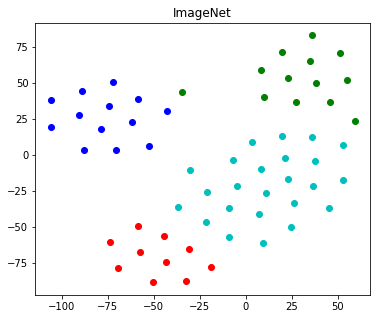

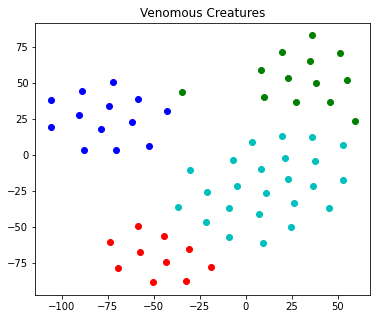

In [254]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0) 

creature_X_2d = tsne.fit_transform(imageNet_feats)
creature_X_2d = tsne.fit_transform(creature_feats)

plt.figure(figsize=(6, 5))
for i in range(creature_X_2d.shape[0]):
  if labels[i] == 0:
    # 0 is Box Jellyfish
    plt.scatter(creature_X_2d[i,0], creature_X_2d[i, 1], c='r')
  if labels[i] == 1:
    # 1 is Funnel Web Spider
    plt.scatter(creature_X_2d[i,0], creature_X_2d[i, 1], c='g')
  if labels[i] == 2:
    # 2 is Mexican Beaded Lizard
    plt.scatter(creature_X_2d[i,0], creature_X_2d[i, 1], c='b')
  if labels[i] == 3:
    # 3 is Saw Scaled Viper
    plt.scatter(creature_X_2d[i,0], creature_X_2d[i, 1], c='c')
plt.title('ImageNet')

plt.figure(figsize=(6, 5))
for i in range(creature_X_2d.shape[0]):
  if labels[i] == 0:
    # 0 is Box Jellyfish
    plt.scatter(creature_X_2d[i,0], creature_X_2d[i, 1], c='r')
  if labels[i] == 1:
    # 1 is Funnel Web Spider
    plt.scatter(creature_X_2d[i,0], creature_X_2d[i, 1], c='g')
  if labels[i] == 2:
    # 2 is Mexican Beaded Lizard
    plt.scatter(creature_X_2d[i,0], creature_X_2d[i, 1], c='b')
  if labels[i] == 3:
    # 3 is Saw Scaled Viper
    plt.scatter(creature_X_2d[i,0], creature_X_2d[i, 1], c='c')
plt.title('Venomous Creatures')
plt.show()